# Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    roc_auc_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
import warnings
warnings.filterwarnings('ignore')

# Load in the Data

In [36]:
tsv_file_path = 'data/updated.tsv'
final_df = pd.read_csv(tsv_file_path, sep='\t')

# Identifying the Features and Target: Quality

In [37]:
X = final_df.drop(['quality'], axis=1)
y = final_df['quality']

# Splitting the Dataset

In [38]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # 20% for testing & we ensure y (quality) maintains the original distribution
)

# Scale the data down?

In [39]:
numerical_cols = [
    'age', 'caffeine', 'nap_length', 'alcohol', 'exercise', 
    'bedtime', 'wakeup_time', 'sleep_duration'
]

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Training the actual Random Forests

In [40]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    random_state=42,           # Ensures reproducibility
    class_weight='balanced'    # Handles class imbalance
)

rf_classifier.fit(X_train_scaled, y_train)
y_pred = rf_classifier.predict(X_test_scaled)

# Accuracy of the Model

Accuracy: 0.6755

Classification Report:
               precision    recall  f1-score   support

         1.0       0.80      0.65      0.72       135
         2.0       0.70      0.77      0.73       193
         3.0       0.61      0.69      0.65       149
         4.0       0.55      0.47      0.50        62
         5.0       0.62      0.52      0.57        25

    accuracy                           0.68       564
   macro avg       0.66      0.62      0.63       564
weighted avg       0.68      0.68      0.67       564

Top 10 Feature Importances:
 rested                 0.197039
depth_of_sleep         0.185672
difficulty_of_sleep    0.067352
M2ID                   0.066051
sleep_duration         0.060053
wakeup_time            0.059584
age                    0.059230
bedtime                0.054186
minutes_to_sleep       0.053249
day                    0.038794
dtype: float64


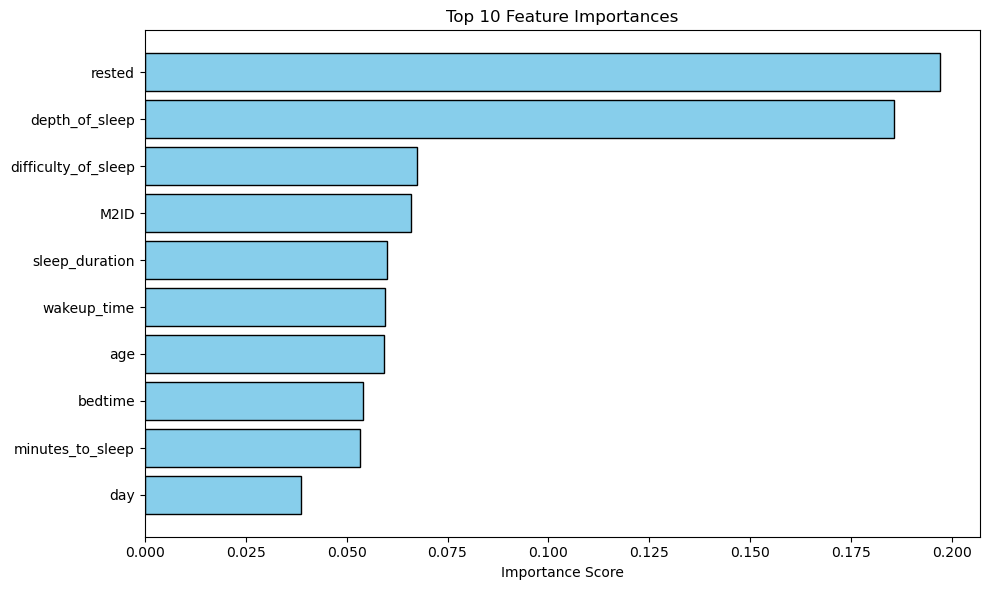

In [41]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Extract feature importances
importances = rf_classifier.feature_importances_
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Display feature importances
print("Top 10 Feature Importances:\n", feature_importances.head(10))

# Plot Feature Importances using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index[:10], feature_importances.values[:10], color='skyblue', edgecolor='black')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# Confusion Matrix

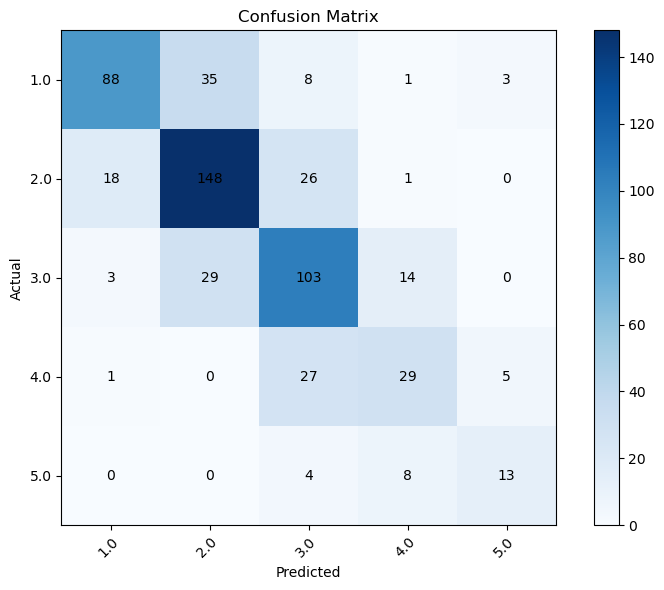

In [42]:
# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
fig.colorbar(im)

# Set ticks and labels
ax.set_xticks(np.arange(len(rf_classifier.classes_)))
ax.set_yticks(np.arange(len(rf_classifier.classes_)))
ax.set_xticklabels(rf_classifier.classes_)
ax.set_yticklabels(rf_classifier.classes_)

# Rotate the tick labels and set alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Annotate the confusion matrix with counts
for i in range(len(rf_classifier.classes_)):
    for j in range(len(rf_classifier.classes_)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
fig.tight_layout()
plt.show()


# ROC Curve for Multi-Class Classification

ROC AUC Score: 0.9125


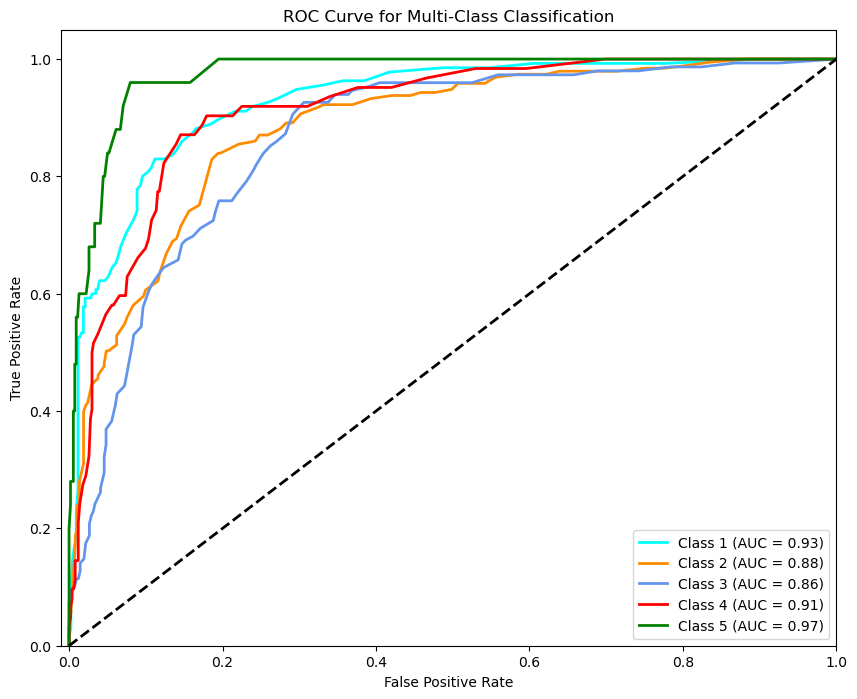

In [43]:
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=[1,2,3,4,5])
n_classes = y_test_binarized.shape[1]

# Get prediction probabilities
y_score = rf_classifier.predict_proba(X_test_scaled)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test_binarized, y_score, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i+1, roc_auc_dict[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


# Hyperparameter Tuning

In [44]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation
    n_jobs=-1,               # Utilize all available cores
    verbose=2,               # Verbosity level
    scoring='accuracy'       # Evaluation metric
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Display the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tota

# Retraining with Best Parameters

Optimized Accuracy: 0.7004

Optimized Classification Report:
               precision    recall  f1-score   support

         1.0       0.83      0.69      0.75       135
         2.0       0.72      0.79      0.75       193
         3.0       0.63      0.71      0.67       149
         4.0       0.57      0.50      0.53        62
         5.0       0.68      0.52      0.59        25

    accuracy                           0.70       564
   macro avg       0.69      0.64      0.66       564
weighted avg       0.71      0.70      0.70       564



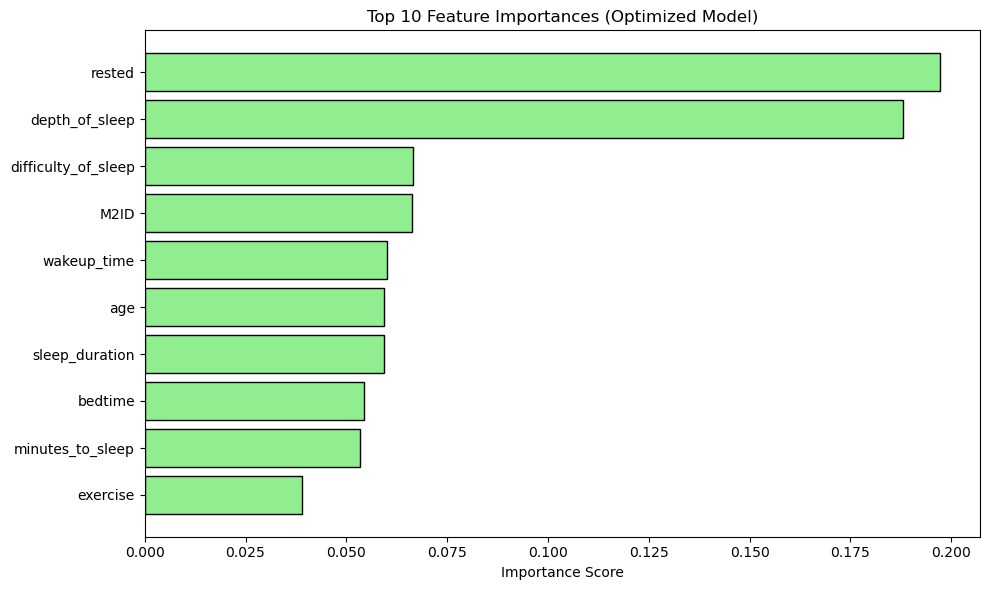

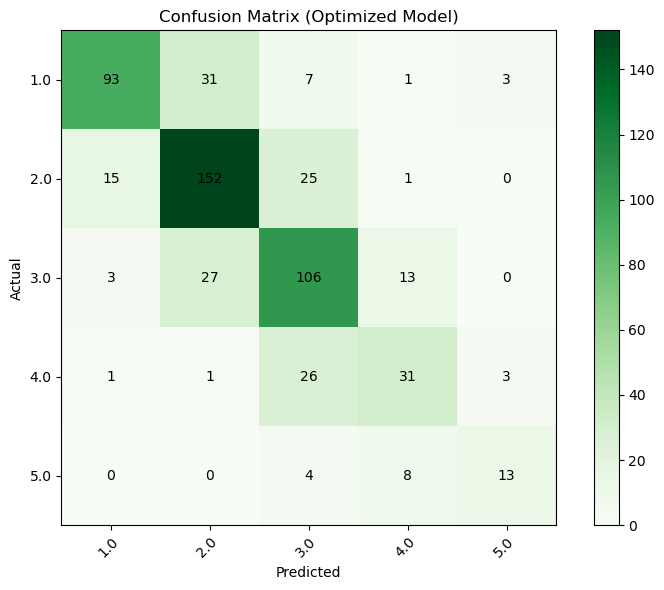

Optimized ROC AUC Score: 0.9151


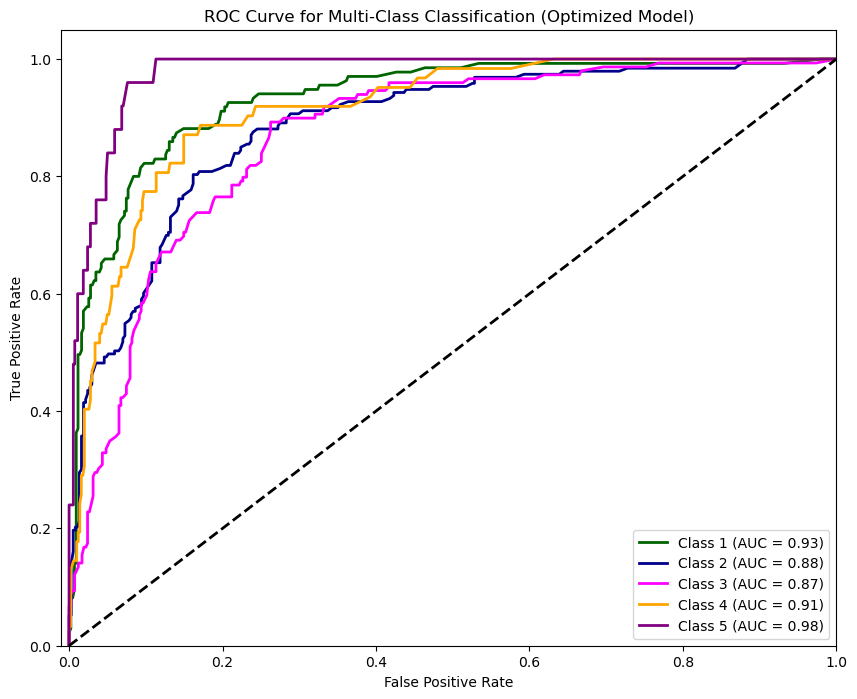

In [46]:
# Extract best parameters from GridSearchCV
best_params = grid_search.best_params_

# Initialize the Random Forest model with best parameters
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42,
    class_weight='balanced'
)

# Train the optimized model
best_rf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_best = best_rf.predict(X_test_scaled)

# Evaluate the optimized model
optimized_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Optimized Accuracy: {optimized_accuracy:.4f}")

# Classification Report for the optimized model
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred_best))

# Feature Importance for the optimized model
importances_best = best_rf.feature_importances_
feature_importances_best = pd.Series(importances_best, index=feature_names).sort_values(ascending=False)

# Plot Feature Importances using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_best.index[:10], feature_importances_best.values[:10], color='lightgreen', edgecolor='black')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances (Optimized Model)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# Confusion Matrix for the optimized model
cm_best = confusion_matrix(y_test, y_pred_best)

# Plot Confusion Matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_best, cmap='Greens')

# Add colorbar
fig.colorbar(im)

# Set ticks and labels
ax.set_xticks(np.arange(len(best_rf.classes_)))
ax.set_yticks(np.arange(len(best_rf.classes_)))
ax.set_xticklabels(best_rf.classes_)
ax.set_yticklabels(best_rf.classes_)

# Rotate the tick labels and set alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Annotate the confusion matrix with counts
for i in range(len(best_rf.classes_)):
    for j in range(len(best_rf.classes_)):
        text = ax.text(j, i, cm_best[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Confusion Matrix (Optimized Model)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
fig.tight_layout()
plt.show()

# ROC Curve for the optimized model
# Binarize the output
y_test_binarized_best = label_binarize(y_test, classes=[1,2,3,4,5])
n_classes_best = y_test_binarized_best.shape[1]

# Get prediction probabilities
y_score_best = best_rf.predict_proba(X_test_scaled)

# Compute ROC AUC
roc_auc_best = roc_auc_score(y_test_binarized_best, y_score_best, average='macro', multi_class='ovr')
print(f"Optimized ROC AUC Score: {roc_auc_best:.4f}")

# Compute ROC curve and ROC area for each class
fpr_best = dict()
tpr_best = dict()
roc_auc_dict_best = dict()

for i in range(n_classes_best):
    fpr_best[i], tpr_best[i], _ = roc_curve(y_test_binarized_best[:, i], y_score_best[:, i])
    roc_auc_dict_best[i] = auc(fpr_best[i], tpr_best[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors_best = ['darkgreen', 'darkblue', 'magenta', 'orange', 'purple']
for i, color in zip(range(n_classes_best), colors_best):
    plt.plot(fpr_best[i], tpr_best[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i+1, roc_auc_dict_best[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification (Optimized Model)')
plt.legend(loc="lower right")
plt.show()


# Cross Validation

In [45]:
# Perform 5-fold cross-validation on the best model
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")

Cross-Validation Scores: [0.65707965 0.6962306  0.66075388 0.6940133  0.6518847 ]
Mean CV Accuracy: 0.6720
Standard Deviation of CV Accuracy: 0.0191
